In [1]:
import re
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import emoji
import warnings
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
def rawToDf(file, key):
    '''Converts raw .txt file into a Data Frame'''
    print(type(file))
    split_formats = {
        '12hr' : '\d{1,2}/\d{1,2}/\d{2,4}\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom' : ''
    }
    datetime_formats = {
        '12hr' : '%d/%m/%y %I:%M %p - ',
        '24hr' : '%d/%m/%Y, %H:%M - ',
        'custom': ''
    }
    
    try:
        with open(file, 'r', encoding='utf-8') as raw_data:
#             print(raw_data.read())
            raw_string = ' '.join(raw_data.read().split('\n')) # converting the list split by newline char. as one whole string as there can be multi-line messages
            user_msg = re.split(split_formats[key], raw_string) [1:] # splits at all the date-time pattern, resulting in list of all the messages with user names
            date_time = re.findall(split_formats[key], raw_string) # finds all the date-time patterns

            df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg}) # exporting it to a df
    except IOError:
        print ('File not accessible')
    except Exception as e:
        print (e.message)
        
    # converting date-time pattern which is of type String to type datetime,
    # format is to be specified for the whole string where the placeholders are extracted by the method 
    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key])
    
    # split user and msg 
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i) # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if(a[1:]): # user typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else: # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("group_notification")
            msgs.append(a[0])

    # creating new columns         
    df['user'] = usernames
    df['message'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)
    
    return df

In [3]:
df = rawToDf('family WhatsApp.txt', '12hr')

<class 'str'>


In [4]:
df['day'] = df['date_time'].dt.strftime('%a')
df['month'] = df['date_time'].dt.strftime('%b')
df['year'] = df['date_time'].dt.year
df['date'] = df['date_time'].apply(lambda x: x.date())

In [5]:
df = df[df.year != 2015]
df.reset_index(inplace=True)
df

,index,date_time,user,message,day,month,year,date
0,0,2020-07-03 21:51:00,group_notification,‏پیغامات اور کالز شروع سے آخر تک رمزکاری کے ذر...,Fri,Jul,2020,2020-07-03
1,2,2020-07-03 21:51:00,group_notification,‏‏‪Bulchi Mamo‬‏ نے آپ کو شامل کیا,Fri,Jul,2020,2020-07-03
2,3,2020-07-03 21:51:00,Khala,Congrats bilal👍👍 Konsa leya??,Fri,Jul,2020,2020-07-03
3,4,2020-07-03 21:52:00,Bulchi Mamo,Bilal pic send kerdo,Fri,Jul,2020,2020-07-03
4,5,2020-07-03 21:52:00,Naseema Khala,Nya phone Mubarak Bilal,Fri,Jul,2020,2020-07-03
...,...,...,...,...,...,...,...,...
1937,1938,2020-11-08 17:41:00,Mama,<Media Omitted>,Sun,Nov,2020,2020-11-08
1938,1939,2020-11-08 19:50:00,Mama,https://www.facebook.com/1087069704638796/post...,Sun,Nov,2020,2020-11-08
1939,1940,2020-11-08 21:10:00,Naseema Khala,https://fb.watch/1DQtBkmwN7/,Sun,Nov,2020,2020-11-08
1940,1941,2020-11-08 21:56:00,Mama,<Media Omitted>,Sun,Nov,2020,2020-11-08


In [6]:
links = 0
linkDf = pd.DataFrame()
for index, row in df.iterrows():
    urls = re.findall(r'(https?://[^\s]+)', row.message)
    if urls:
        links = links + len(urls)
        linkDf = linkDf.append(row, ignore_index=True)
print("Links obtained: ", links)
linkDf

Links obtained:  66


,date,date_time,day,index,message,month,user,year
0,2020-07-06,2020-07-06 06:42:00,Mon,94.0,It’s getting crazier everyday 😂 https://apple....,Jul,Naseema Khala,2020.0
1,2020-07-10,2020-07-10 15:18:00,Fri,141.0,https://www.facebook.com/100048556726301/posts...,Jul,Najm Uncle,2020.0
2,2020-07-10,2020-07-10 23:41:00,Fri,146.0,https://m.facebook.com/story.php?story_fbid=13...,Jul,Nana,2020.0
3,2020-07-11,2020-07-11 07:25:00,Sat,147.0,https://youtu.be/vuQwzKILU9I,Jul,Naseema Khala,2020.0
4,2020-07-11,2020-07-11 22:24:00,Sat,154.0,https://www.facebook.com/100000545271709/posts...,Jul,Bulchi Mamo,2020.0
...,...,...,...,...,...,...,...,...
61,2020-10-31,2020-10-31 18:33:00,Sat,1855.0,"Sean Connery, Oscar winner and James Bond star...",Oct,Naseema Khala,2020.0
62,2020-11-02,2020-11-02 12:31:00,Mon,1876.0,https://www.facebook.com/hafiz.mughal.982/vide...,Nov,Mama,2020.0
63,2020-11-04,2020-11-04 06:26:00,Wed,1892.0,See the fence being built around the White Hou...,Nov,Naseema Khala,2020.0
64,2020-11-08,2020-11-08 19:50:00,Sun,1939.0,https://www.facebook.com/1087069704638796/post...,Nov,Mama,2020.0


In [7]:
linkDf = linkDf.groupby("user")["message"].count().sort_values(ascending=False)
linkDf = pd.DataFrame({'user':linkDf.index, 'no_links':linkDf.values})
linkDf

,user,no_links
0,Mama,25
1,Naseema Khala,13
2,Nana,8
3,Najm Uncle,8
4,Baba,7
5,Raafay Bhai,2
6,Maaz Quraishi,1
7,Khala,1
8,Bulchi Mamo,1


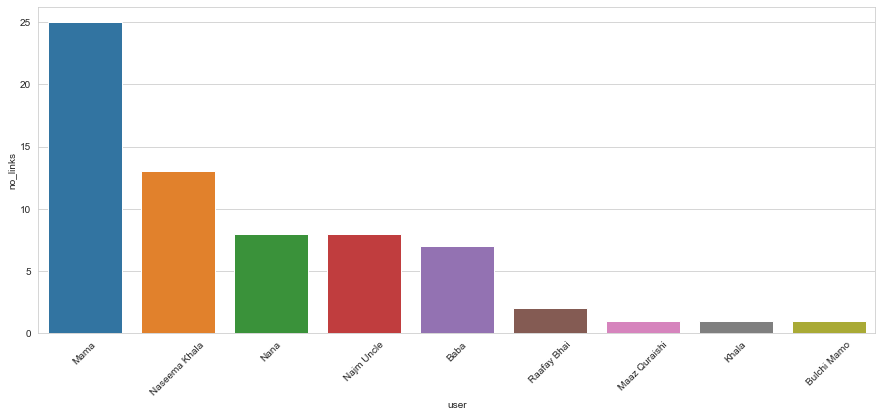

In [8]:
# Beautifying Default Styles using Seaborn
sns.set_style("whitegrid")
plt.figure(figsize=(15, 6))
plt.xticks(rotation=45)
sns.barplot(linkDf.user, linkDf.no_links, data=linkDf);

In [9]:
df1 = df.copy()      # I will be using a copy of the original data frame everytime, to avoid loss of data!
df1['message_count'] = [1] * df1.shape[0]      # adding extra helper column --> message_count.
df1.drop(columns='year', inplace=True)         # dropping unnecessary columns, using `inplace=True`, since this is copy of the DF and won't affect the original DataFrame.
df1 = df1.groupby('date').sum().reset_index()  # grouping by date; since plot is of frequency of messages --> no. of messages / day.
df1.drop(0, inplace=True)
df1

,date,index,message_count
1,2020-07-04,609,14
2,2020-07-05,2380,35
3,2020-07-06,3015,30
4,2020-07-07,590,5
5,2020-07-08,1518,12
...,...,...,...
122,2020-11-04,41635,22
123,2020-11-05,19085,10
124,2020-11-06,1914,1
125,2020-11-07,34623,18


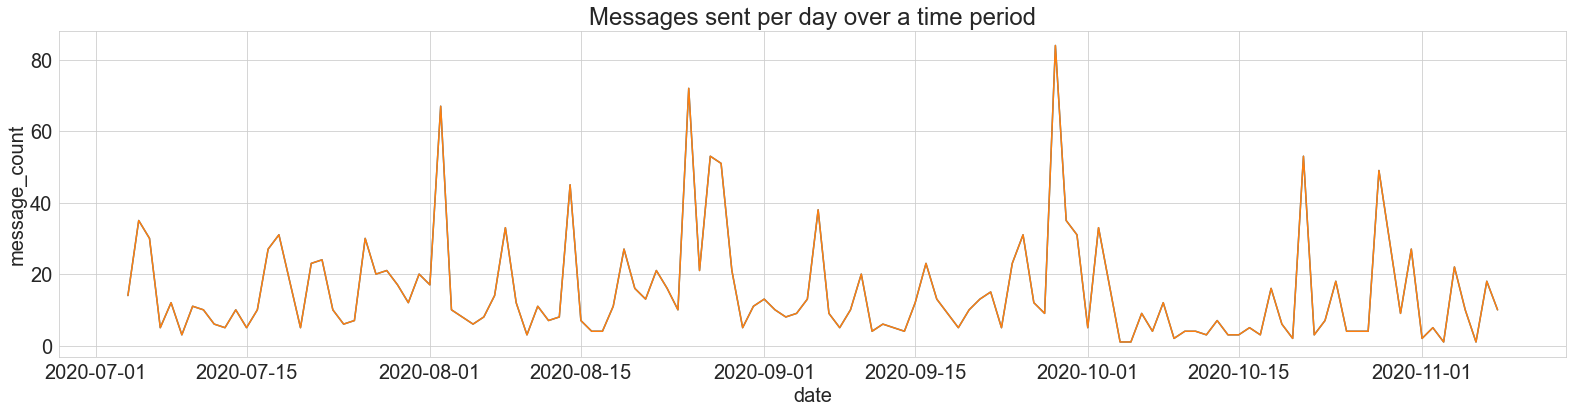

In [10]:
# Improving Default Styles using Seaborn
sns.set_style("whitegrid")

# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (27, 6)      # Same as `plt.figure(figsize = (27, 6))`


# A basic plot
plt.plot(df1.date, df1.message_count)
plt.title('Messages sent per day over a time period');

# Could have used Seaborn's lineplot as well.
sns.lineplot(df1.date, df1.message_count);   


# Saving the plots
# plt.savefig('msg_plots.svg', format = 'svg')

In [11]:
top10days = df1.sort_values(by="message_count", ascending=False).head(10)    # Sort values according to the number of messages per day.
top10days.reset_index(inplace=True)           # reset index in order.
top10days.drop(columns="index", inplace=True) # dropping original indices.
top10days

,level_0,date,message_count
0,87,2020-09-28,84
1,53,2020-08-25,72
2,30,2020-08-02,67
3,55,2020-08-27,53
4,110,2020-10-21,53
5,56,2020-08-28,51
6,116,2020-10-28,49
7,42,2020-08-14,45
8,65,2020-09-06,38
9,2,2020-07-05,35


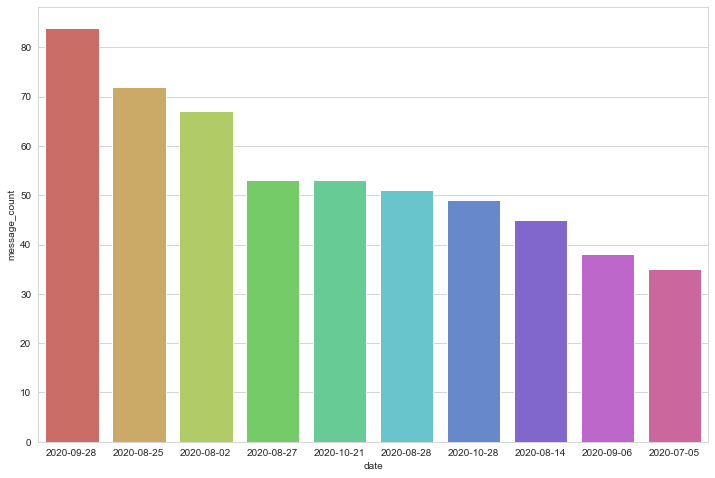

In [12]:
# Improving Default Styles using Seaborn
sns.set_style("whitegrid")

# For better readablity;
# import matplotlib
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (12, 8)

# A bar plot for top 10 days
sns.barplot(top10days.date, top10days.message_count, palette="hls");

# Saving the plots
# plt.savefig('top10_days.svg', format = 'svg')

In [13]:
# Total number of people who have sent at least one message on the group;
print(f"Total number of people who have sent at least one message on the group are {len(df.user.unique()) - 1}")   # `-1` because excluding "group_notficiation"

print(f"Number of people who haven't sent even a single message on the group are {20 - (len(df.user.unique()) - 1)}")

Total number of people who have sent at least one message on the group are 19
Number of people who haven't sent even a single message on the group are 1


In [14]:
print(df.user.unique())
len(df.user.unique())

['group_notification' 'Khala' 'Bulchi Mamo' 'Naseema Khala' 'Raafay Bhai'
 'Bilal Khan' 'Soban Bhai' 'Mama' 'Ammar Quraishi' 'Najm Uncle' 'Baba'
 'Nana' 'Baray Mamo' 'Huzaifa' 'Umair' 'Rabiyah Iftikhar' 'Samra Raafay'
 'Maaz Quraishi' 'Haaris Khalique' 'Samia Bhabi']


20

In [15]:
df2 = df.copy()    
df2 = df2[df2.user != "group_notification"]
top10df = df2.groupby("user")["message"].count().sort_values(ascending=False)

# Final Data Frame
top10df = top10df.reset_index()
top10df

,user,message
0,Mama,567
1,Baba,324
2,Bulchi Mamo,257
3,Naseema Khala,178
4,Khala,174
5,Najm Uncle,117
6,Nana,83
7,Raafay Bhai,62
8,Baray Mamo,45
9,Bilal Khan,37


In [16]:
df[df.user == 'Umair']

,index,date_time,user,message,day,month,year,date
84,85,2020-07-05 22:40:00,Umair,Sylvester,Sun,Jul,2020,2020-07-05
887,888,2020-08-25 14:12:00,Umair,Happy Birthday Haaris Bhai.,Tue,Aug,2020,2020-08-25
1217,1218,2020-09-12 19:17:00,Umair,<Media Omitted>,Sat,Sep,2020,2020-09-12
1368,1369,2020-09-25 20:38:00,Umair,Happy birthday Raafay Bhai.,Fri,Sep,2020,2020-09-25
1536,1537,2020-09-30 16:25:00,Umair,Happy Birthday Bulchi Mamo.,Wed,Sep,2020,2020-09-30


In [17]:
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

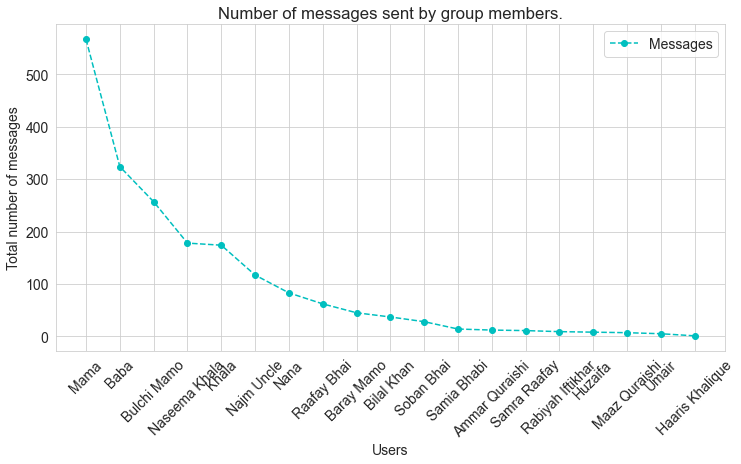

In [18]:
# Improving Default Styles using Seaborn
sns.set_style("whitegrid")

# Increasing the figure size
plt.figure(figsize=(12, 6))


# plt.plot(top10df.initials, top10df.message, marker='o', ls='--', c='cyan')

# BETTER IMPLEMENTATION using the `fmt` argument;
plt.plot(top10df.user, top10df.message, 'o--c')  


# Labels and Title 
plt.xlabel('Users')
plt.ylabel('Total number of messages')

plt.xticks(rotation=45)

plt.title("Number of messages sent by group members.")
plt.legend(['Messages']);

# Saving the plots
# plt.savefig('msg_plots.svg', format = 'svg')

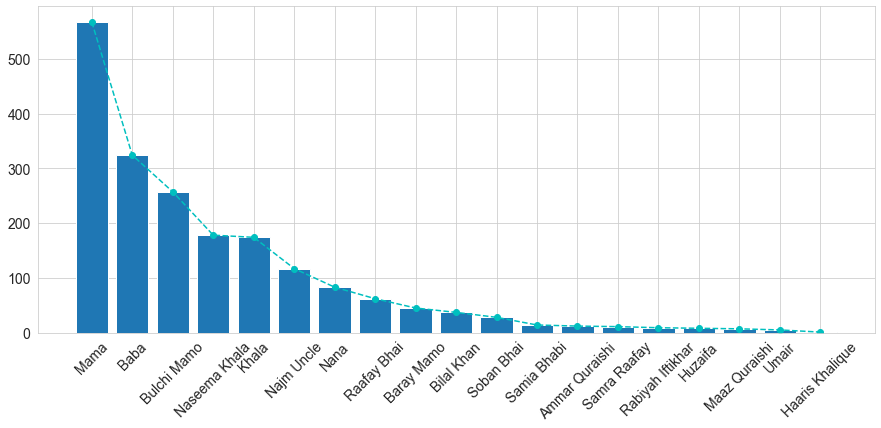

In [19]:
# Improving Default Styles using Seaborn
sns.set_style("whitegrid")

# Increasing the figure size
plt.figure(figsize=(15, 6))
plt.xticks(rotation=45)

plt.bar(top10df.user, top10df.message)   # basic bar chart
plt.plot(top10df.user, top10df.message, 'o--c');   # line chart

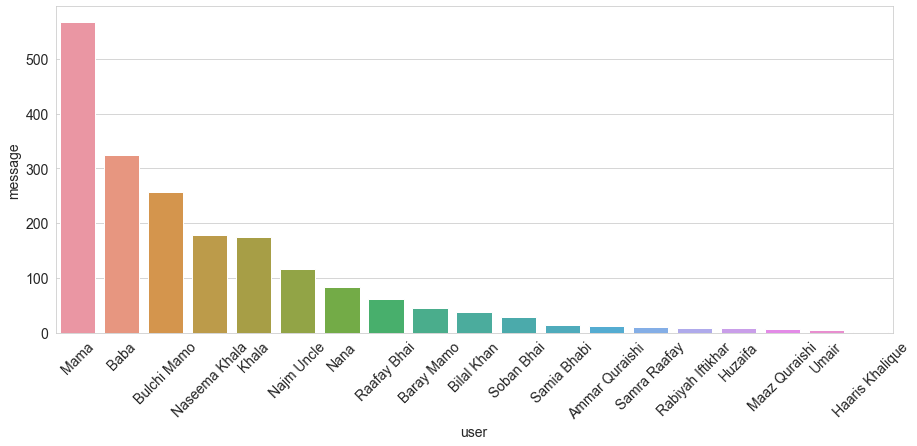

In [20]:
# Beautifying Default Styles using Seaborn
sns.set_style("whitegrid")
plt.figure(figsize=(15, 6))
plt.xticks(rotation=45)
sns.barplot(top10df.user, top10df.message, data=top10df);

In [21]:
def get_colors_of_certain_order(names_in_certain_order):
    '''the color of a certain person remains the same, no matter the plot'''
    
    order = list(names_in_certain_order)
    return_list = []
    
    for name in order:
        return_list.append(color_dict[name])
        
    return return_list

{'Mama': '#F94144',
 'Baba': '#F3722C',
 'Bulchi Mamo': '#F8961E',
 'Naseema Khala': '#FDC500',
 'Khala': '#F9C74F',
 'Najm Uncle': '#90BE6D',
 'Nana': '#43AA8B',
 'Raafay Bhai': '#577590',
 'Baray Mamo': '#6D597A',
 'Bilal Khan': '#003F88',
 'Soban Bhai': '#260C1A',
 'Samia Bhabi': '#EDBFC6',
 'Ammar Quraishi': '#C7D66D',
 'Samra Raafay': '#7A7978',
 'Rabiyah Iftikhar': '#DEF6CA',
 'Huzaifa': '#F65BE3',
 'Maaz Quraishi': '#1E3F20',
 'Umair': '#AC80A0',
 'Haaris Khalique': '#5C1A1B'}

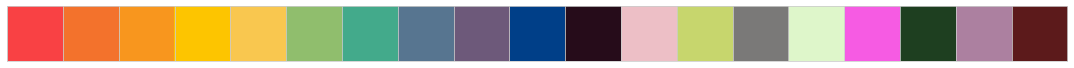

In [22]:
colors = ['#F94144', '#F3722C', '#F8961E', '#FDC500', '#F9C74F', '#90BE6D', '#43AA8B', '#577590', '#6D597A','#003F88', '#260C1A', '#EDBFC6', '#C7D66D', '#7A7978', '#DEF6CA', '#F65BE3', '#1E3F20', '#AC80A0', '#5C1A1B']
sns.palplot(colors)    # visualizing the colors' list

names = top10df.user

color_dict = {}
for name, color in zip(names, colors):
    color_dict[name] = color
color_dict

In [23]:
# Adding another column for message length; using the apply method;
df2['message_length'] = df2['message'].apply(lambda x: len(x))
only10df = top10df.head(10)

# Creating another dataframe for average length per user;
avg_msg_lengths = df2.groupby(df2.user).mean().reset_index().sort_values(by = 'message_length', ascending = False)

# Creating helper columns;
only10df['avg_message_length'] = [0] * 10
i, j = 0, 0
while i < 10:
    if only10df['user'][i] == avg_msg_lengths['user'][j]:
        only10df['avg_message_length'][i] = avg_msg_lengths['message_length'][j]
        i += 1
        j = -1
    j += 1

# Sorting the average message lengths of the same to 10 active users;
top10df_msg = only10df.sort_values(by = "avg_message_length", ascending=False)

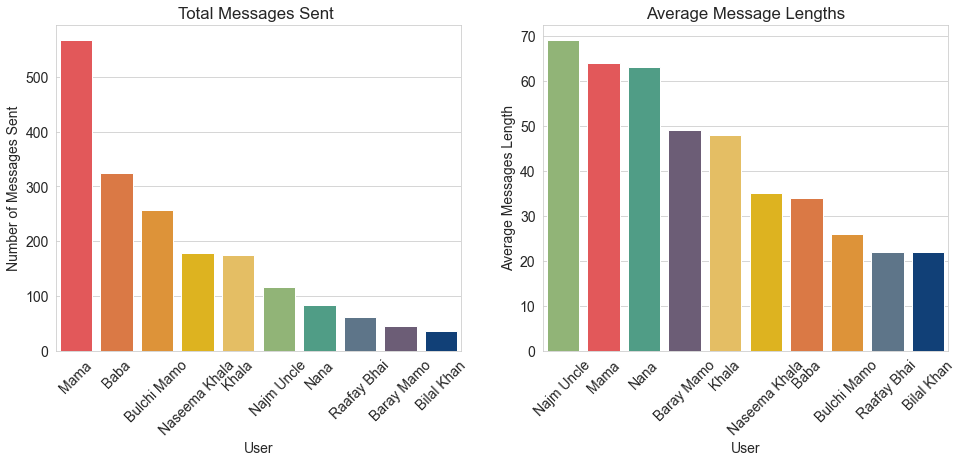

In [24]:
# plotting multiple charts in a grid
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.set_style("whitegrid")

plt.sca(axes[0])
plt.xticks(rotation=45)
plt.sca(axes[1])
plt.xticks(rotation=45)

# Plot 1 - Countplot of total messages sent
sns.barplot(only10df.user, only10df.message, data=only10df, ax = axes[0], palette=get_colors_of_certain_order(only10df.user));     # Note: the palette argument;

axes[0].set_title('Total Messages Sent ')
axes[0].set_xlabel('User')
axes[0].set_ylabel('Number of Messages Sent')

# Plot 2 - Barplot of those top 10 users' average message lengths
sns.barplot(top10df_msg.user, top10df_msg.avg_message_length, ax = axes[1], palette = get_colors_of_certain_order(top10df_msg.user))    # Note: the respective palette argument;

axes[1].set_title('Average Message Lengths')
axes[1].set_xlabel('User');
axes[1].set_ylabel('Average Messages Length');

# Saving the plots
# plt.savefig('top10_msg_plots_diff.svg', format = 'svg')

In [25]:
# Using `groupby`, `count` and `sort_values` attributes.
top10media = df[df.message == '<Media Omitted> '].groupby('user').count().sort_values(by="message", ascending = False)

# Dropping unused column;
top10media.drop(columns=['date_time', 'day', 'month', 'year', 'date'], inplace=True)

# Renaming column name for visualization;
top10media.rename(columns={"message": "media_sent"}, inplace=True)

# resetting index;
top10media.reset_index(inplace=True)

# top10media['initials'] = ''
# for i in range(10):
#     top10media.initials[i] = top10media.user[i].split()[0][0] + top10media.user[i].split()[1][0]

# top10media.initials[2] = "Me"    # That's me
# top10media.initials[9] = "VR"

In [26]:
top10media

,user,index,media_sent
0,Mama,379,379
1,Baba,225,225
2,Bulchi Mamo,127,127
3,Khala,107,107
4,Najm Uncle,48,48
5,Naseema Khala,43,43
6,Baray Mamo,31,31
7,Raafay Bhai,25,25
8,Nana,18,18
9,Ammar Quraishi,7,7


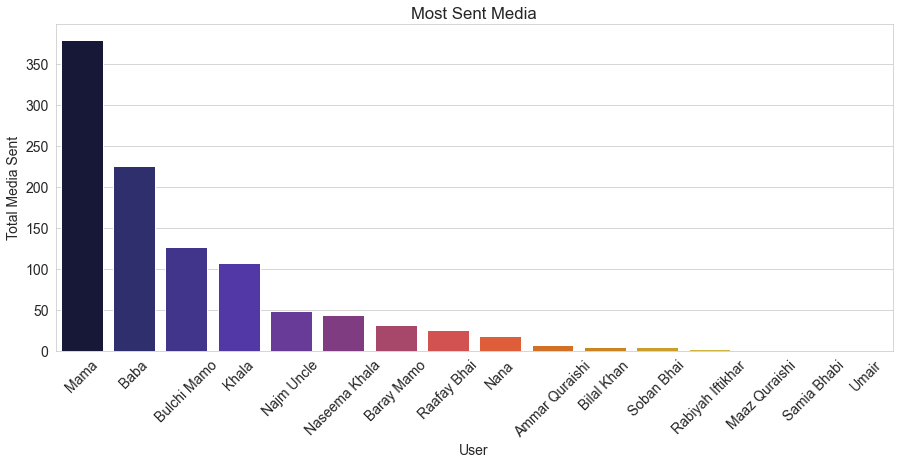

In [27]:
# Increasing the figure size
plt.figure(figsize=(15, 6))

# Beautifying Default Styles using Seaborn
sns.set_style("whitegrid")

# Plotting a bar graph;
sns.barplot(top10media.user, top10media.media_sent, palette="CMRmap");

plt.xticks(rotation=45)
plt.title('Most Sent Media')
plt.xlabel('User')
plt.ylabel('Total Media Sent');

# Saving the plots
# plt.savefig('top10media.svg', format = 'svg')

In [28]:
emoji_ctr = Counter()
emojis_list = map(lambda x: ''.join(x.split()), emoji.UNICODE_EMOJI.keys())
r = re.compile('|'.join(re.escape(p) for p in emojis_list))
for idx, row in df.iterrows():
    emojis_found = r.findall(row["message"])
    for emoji_found in emojis_found:
        emoji_ctr[emoji_found] += 1

In [29]:
top10emojis = pd.DataFrame()
# top10emojis = pd.DataFrame(data, columns={"emoji", "emoji_description", "emoji_count"}) 
top10emojis['emoji'] = [''] * 10
top10emojis['emoji_count'] = [0] * 10
top10emojis['emoji_description'] = [''] * 10

i = 0
for item in emoji_ctr.most_common(10):
    # will be using another helper column, since during visualization, the emojis won't be rendered.
    description = emoji.demojize(item[0])[1:-1]    # using `[1:-1]` to remove the colons ':' at the end of the demojized strin
    
    # appending top 10 data of emojis.  # Loading into a DataFrame.
    top10emojis.emoji[i] = item[0]
    top10emojis.emoji_count[i] = int(item[1])
    top10emojis.emoji_description[i] = description
    i += 1

top10emojis

,emoji,emoji_count,emoji_description
0,👍,117,thumbs_up
1,😂,93,face_with_tears_of_joy
2,🤣,54,rolling_on_the_floor_laughing
3,😍,49,smiling_face_with_heart-eyes
4,😄,46,grinning_face_with_smiling_eyes
5,❤,38,red_heart
6,🎈,34,balloon
7,🎂,31,birthday_cake
8,😁,30,beaming_face_with_smiling_eyes
9,💕,30,two_hearts


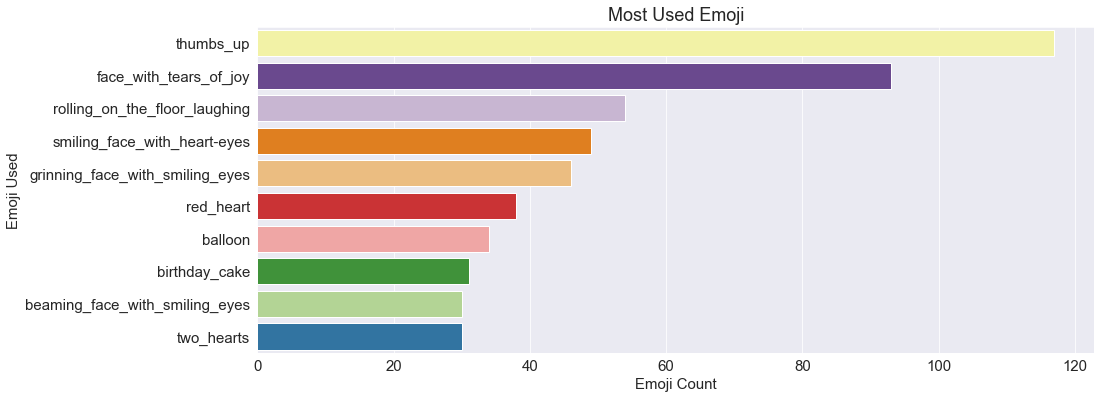

In [30]:
# Increasing the figure size
plt.figure(figsize=(15, 6))

# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 15

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting;
sns.barplot(top10emojis.emoji_count, top10emojis.emoji_description, palette = "Paired_r")

plt.title('Most Used Emoji')
plt.xlabel('Emoji Count')
plt.ylabel('Emoji Used');

# Saving the plots
# plt.savefig('top10emoji.svg', format = 'svg')

In [31]:
df3 = df.copy()
df3['message_count'] = [1] * df.shape[0]    # helper column to keep a count.

df3['hour'] = df3['date_time'].apply(lambda x: x.hour)

grouped_by_time = df3.groupby('hour').sum().reset_index().sort_values(by = 'hour')

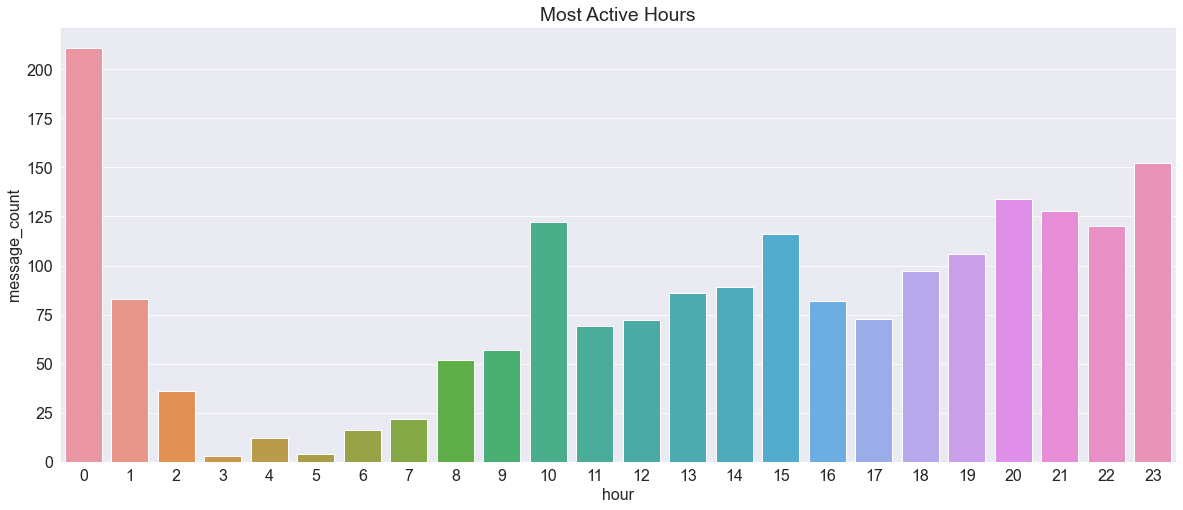

In [32]:
# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (20, 8)

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# PLOT: grouped by hour
sns.barplot(grouped_by_time.hour, grouped_by_time.message_count)
plt.title('Most Active Hours');

# Saving the plots;
# plt.savefig('most_active_hours.svg', format = 'svg')

In [33]:
# specific `order` to be printed in;
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
# grouping by day;
grouped_by_day = df3.groupby('day').sum().reset_index()[['day', 'message_count']]


# specific `order` to be printed in;
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']   # till Sept, since chats are till Septemeber
# grouping by month;
grouped_by_month = df3.groupby('month').sum().reset_index()[['month', 'message_count']]

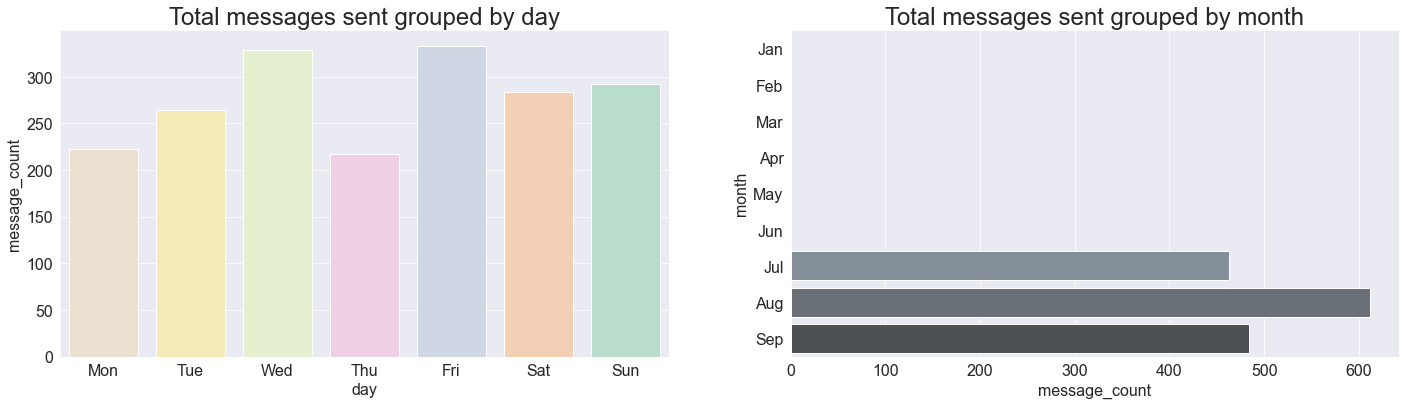

In [34]:
fig, axs = plt.subplots(1, 2, figsize = (24, 6))

# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 20

# Beautifying Default Styles using Seaborn
sns.set_style("whitegrid")

# Plotting;

# PLOT 1: Messages grouped by weekday
sns.barplot(grouped_by_day.day, grouped_by_day.message_count, order=days, ax = axs[0], palette='Pastel2_r')
axs[0].set_title('Total messages sent grouped by day')

# PLOT 2: Messages grouped by months
sns.barplot(y = grouped_by_month.month, x=grouped_by_month.message_count, order = months, ax = axs[1], palette='Pastel1_d')
axs[1].set_title('Total messages sent grouped by month');

# Saving the plots;
# plt.savefig('days_and_month.svg', format = 'svg')

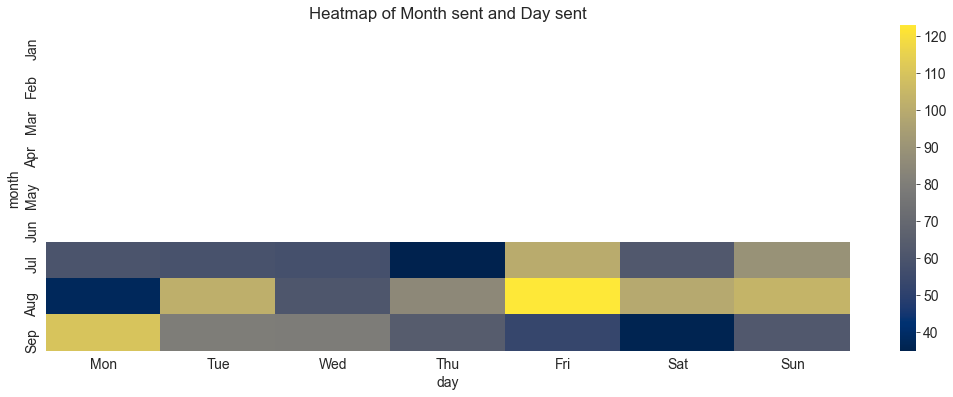

In [35]:
# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (18, 6)

# Beautifying Default Styles using Seaborn,
sns.set_style("whitegrid")

# Pre-Processing by month and day,
grouped_by_month_and_day = df3.groupby(['month', 'day']).sum().reset_index()[['month', 'day', 'message_count']]

# creating a pivot table,
pt = grouped_by_month_and_day.pivot_table(index = 'month', columns = 'day', values = 'message_count').reindex(index = months, columns = days)

# PLOT: heatmap.
sns.heatmap(pt, cmap = 'cividis');
plt.title('Heatmap of Month sent and Day sent');

# Saving the plots;
plt.savefig('month_day_heatmap.svg', format = 'svg')

In [36]:
def is_ascii(s):
#     return all(ord(c) < 128 for c in s)
    if (len(s) == len(s.encode())):
        urls = re.findall(r'(https?://[^\s]+)', s)
        if urls:
            return False
        else:
            return True

In [37]:
df4 = pd.DataFrame()
for index, row in df3.iterrows():
    english = is_ascii(row.message)
    if (english):
        df4 = df4.append(row, ignore_index=True)
df4

,date,date_time,day,hour,index,message,message_count,month,user,year
0,2020-07-03,2020-07-03 21:52:00,Fri,21.0,4.0,Bilal pic send kerdo,1.0,Jul,Bulchi Mamo,2020.0
1,2020-07-03,2020-07-03 21:52:00,Fri,21.0,5.0,Nya phone Mubarak Bilal,1.0,Jul,Naseema Khala,2020.0
2,2020-07-03,2020-07-03 21:53:00,Fri,21.0,8.0,Every person in this group should be admin :p,1.0,Jul,Raafay Bhai,2020.0
3,2020-07-03,2020-07-03 21:55:00,Fri,21.0,9.0,Phir Bilal ko 2 phones rkhnay hongay... aik ba...,1.0,Jul,Naseema Khala,2020.0
4,2020-07-03,2020-07-03 21:56:00,Fri,21.0,10.0,<Media Omitted>,1.0,Jul,Bilal Khan,2020.0
...,...,...,...,...,...,...,...,...,...,...
1314,2020-11-08,2020-11-08 17:39:00,Sun,17.0,1936.0,<Media Omitted>,1.0,Nov,Mama,2020.0
1315,2020-11-08,2020-11-08 17:40:00,Sun,17.0,1937.0,<Media Omitted>,1.0,Nov,Mama,2020.0
1316,2020-11-08,2020-11-08 17:41:00,Sun,17.0,1938.0,<Media Omitted>,1.0,Nov,Mama,2020.0
1317,2020-11-08,2020-11-08 21:56:00,Sun,21.0,1941.0,<Media Omitted>,1.0,Nov,Mama,2020.0


In [38]:
comment_words = ' '

# stopwords --> Words to be avoided while forming the WordCloud,
# removed group_notifications like 'joined', 'deleted';
# removed really common words like "yeah" and "okay".
stopwords = STOPWORDS.update(['tu', 'hay', 'yai', 'aur', 'ab', 'kia', 'liye', 'abhi', 'aap', 'ky', 'bhi', 'ki', 'nahi', 'rahi', 'group', 'link', 'invite', 'joined', 'message', 'deleted', 'yeah', 'hai', 'yes', 'okay', 'ka', 'na', 'ok', 'will', 'use', 'using', 'one', 'know', 'guy', 'group', 'media', 'omitted'])


# iterate through the DataFrame.
for val in df4.message.values:
    
    # typecaste each val to string.
    val = str(val) 
    
    # split the value.
    tokens = val.split() 
    
    # Converts each token into lowercase.
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 8).generate(comment_words) 

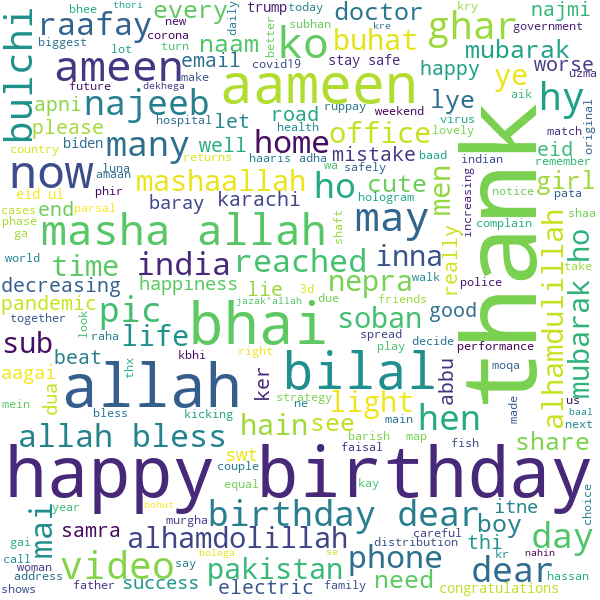

In [39]:
wordcloud.to_image()

In [61]:
df

,index,date_time,user,message,day,month,year,date
0,0,2020-07-03 21:51:00,group_notification,‏پیغامات اور کالز شروع سے آخر تک رمزکاری کے ذر...,Fri,Jul,2020,2020-07-03
1,2,2020-07-03 21:51:00,group_notification,‏‏‪Bulchi Mamo‬‏ نے آپ کو شامل کیا,Fri,Jul,2020,2020-07-03
2,3,2020-07-03 21:51:00,Khala,Congrats bilal👍👍 Konsa leya??,Fri,Jul,2020,2020-07-03
3,4,2020-07-03 21:52:00,Bulchi Mamo,Bilal pic send kerdo,Fri,Jul,2020,2020-07-03
4,5,2020-07-03 21:52:00,Naseema Khala,Nya phone Mubarak Bilal,Fri,Jul,2020,2020-07-03
...,...,...,...,...,...,...,...,...
1937,1938,2020-11-08 17:41:00,Mama,<Media Omitted>,Sun,Nov,2020,2020-11-08
1938,1939,2020-11-08 19:50:00,Mama,https://www.facebook.com/1087069704638796/post...,Sun,Nov,2020,2020-11-08
1939,1940,2020-11-08 21:10:00,Naseema Khala,https://fb.watch/1DQtBkmwN7/,Sun,Nov,2020,2020-11-08
1940,1941,2020-11-08 21:56:00,Mama,<Media Omitted>,Sun,Nov,2020,2020-11-08


In [71]:
# messageCount = df.copy()
# messageCount['message_count'] = [1] * messageCount.shape[0]
# messageCount.drop(columns='year', inplace=True)
# messageCount = messageCount.groupby('date').sum().reset_index()
# messageCount.drop(0, inplace=True)

messageByUser = df.copy()
messageByUser = messageByUser.drop(['day', 'month', 'year', 'date_time', 'index'], axis=1)
messageByUser['message_count'] = [1] * messageByUser.shape[0]
messageByUser = messageByUser[messageByUser.user == 'Mama'].groupby('date').sum().reset_index()
messageByUser

,date,message_count
0,2020-07-03,3
1,2020-07-05,5
2,2020-07-06,10
3,2020-07-07,1
4,2020-07-08,3
...,...,...
111,2020-11-03,1
112,2020-11-04,2
113,2020-11-05,4
114,2020-11-07,4


In [67]:
messageCount = df.copy()
messageCount['message_count'] = [1] * messageCount.shape[0]
messageCount.drop(columns='year', inplace=True)
messageCount = messageCount.groupby('date').sum().reset_index()
messageCount.drop(0, inplace=True)
messageCount

,date,index,message_count
1,2020-07-04,609,14
2,2020-07-05,2380,35
3,2020-07-06,3015,30
4,2020-07-07,590,5
5,2020-07-08,1518,12
...,...,...,...
122,2020-11-04,41635,22
123,2020-11-05,19085,10
124,2020-11-06,1914,1
125,2020-11-07,34623,18
